In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

In [2]:
data = pd.read_csv('Sorghum_Hyperspectral_Data_1820.csv')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,crop,PlotID,year,trt,pheno,CHL,EWT,LWC,SLA,N,...,X2491,X2492,X2493,X2494,X2495,X2496,X2497,X2498,X2499,X2500
0,sorghum,281,2018,greenhouse,yes,446.944,0.021140,0.801818,191.380472,2.84,...,0.057221,0.057268,0.057137,0.056709,0.056457,0.056115,0.055923,0.055987,0.055888,0.055737
1,sorghum,282,2018,greenhouse,yes,713.800,0.013651,0.718788,187.244828,3.44,...,0.065625,0.065636,0.065593,0.065518,0.065329,0.065109,0.064884,0.064390,0.064180,0.064182
2,sorghum,283,2018,greenhouse,yes,724.911,0.013870,0.715429,181.260442,3.52,...,0.061687,0.061462,0.061244,0.061186,0.060975,0.060398,0.060287,0.060618,0.060535,0.060500
3,sorghum,284,2018,greenhouse,yes,738.400,0.016723,0.753034,182.327753,4.13,...,0.055341,0.055124,0.054997,0.055162,0.055078,0.054760,0.054617,0.054473,0.054353,0.054351
4,sorghum,285,2018,greenhouse,yes,700.344,0.023406,0.798125,168.909288,3.85,...,0.056971,0.057206,0.057154,0.056835,0.056743,0.056700,0.056552,0.056538,0.056412,0.056039


In [4]:
data.year.value_counts(dropna= False)

2020    1470
2018     321
Name: year, dtype: int64

In [5]:
data.shape

(1791, 2171)

In [6]:
data.columns[1:50]

Index(['PlotID', 'year', 'trt', 'pheno', 'CHL', 'EWT', 'LWC', 'SLA', 'N', 'P',
       'K', 'Mg', 'Ca', 'S', 'Fe', 'Mn', 'B', 'Cu', 'Zn', 'X350', 'X351',
       'X352', 'X353', 'X354', 'X355', 'X356', 'X357', 'X358', 'X359', 'X360',
       'X361', 'X362', 'X363', 'X364', 'X365', 'X366', 'X367', 'X368', 'X369',
       'X370', 'X371', 'X372', 'X373', 'X374', 'X375', 'X376', 'X377', 'X378',
       'X379'],
      dtype='object')

In [7]:
data.loc[: , 'trt'].value_counts(dropna = False)

HN            738
LN            732
greenhouse    321
Name: trt, dtype: int64

In [8]:
#define the trait for analysis
trait = 'Cu'


In [9]:
#Drop NAs 
data = data.loc[data[trait].notnull(), :]
data.shape

(587, 2171)

In [10]:
##Choose the year
##data= data.loc[data['year'] ==  2020 , :]

<AxesSubplot:xlabel='year', ylabel='Cu'>

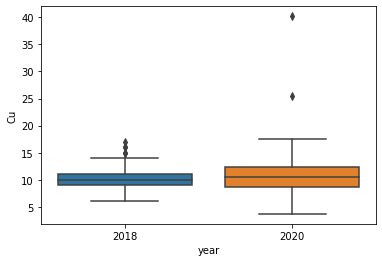

In [11]:
sns.boxplot(y= trait, x='year', data=data)

In [12]:
#defining a function to remove the outliers
def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1=datacolumn.quantile(0.25)
 Q3=datacolumn.quantile(0.75)
 #Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [13]:
outlier_treatment(data[trait])


(4.724999999999998, 16.125000000000004)

In [14]:
lowerbound,upperbound = outlier_treatment(data[trait])

In [15]:
rm_index =data[(data[trait] < lowerbound) | (data[trait] > upperbound)].index
rm_index

Int64Index([214, 321, 327, 389, 804, 856, 857, 920, 1043, 1354, 1479, 1734], dtype='int64')

In [16]:
data.drop(rm_index, axis=0 ,inplace=True)

In [17]:
# choose the years for grouping in the plots
year = data.loc[: , 'year']

In [18]:
data.shape


(575, 2171)

In [19]:
# define trait data
y = data.loc[: , trait]


In [20]:
#select the columns of HR data
spec_columns = [col for col in data if col.startswith('X')]


In [21]:
# Define the X by choosing only the predictors
X = data[spec_columns]


In [22]:
# Apply Savitzky Golay Filter
X = savgol_filter(X, window_length=5 , polyorder = 2)
X = pd.DataFrame(X, columns= spec_columns)

In [23]:
# Remove first 100 wawelengths
X = X.drop(X.columns[0:100], axis=1)

In [24]:
# Create a np array for downsampling for every 5 nm
column_filter = np.arange(0, 2050, 5)

In [25]:
# Choose from the X based on filtering array
X = X.iloc[: , column_filter]


In [26]:
X.head()

,X450,X455,X460,X465,X470,X475,X480,X485,X490,X495,...,X2450,X2455,X2460,X2465,X2470,X2475,X2480,X2485,X2490,X2495
0,0.072084,0.072281,0.074527,0.073938,0.073444,0.073933,0.074270,0.074302,0.074556,0.077044,...,0.067297,0.065572,0.064134,0.062460,0.061316,0.059724,0.058408,0.057898,0.057136,0.056414
1,0.071562,0.070789,0.072950,0.072189,0.071799,0.072144,0.072596,0.072355,0.072260,0.073828,...,0.078345,0.076368,0.074371,0.072508,0.071027,0.069200,0.068060,0.066575,0.065758,0.065334
2,0.067849,0.067549,0.069338,0.068589,0.068386,0.068461,0.068986,0.068710,0.068470,0.070524,...,0.075083,0.073046,0.070950,0.068873,0.067303,0.065461,0.063934,0.062901,0.061841,0.060885
3,0.064959,0.064509,0.066153,0.065387,0.065025,0.065148,0.065500,0.065179,0.065041,0.066772,...,0.064992,0.063572,0.061879,0.060338,0.059434,0.058130,0.057164,0.056357,0.055493,0.055044
4,0.066446,0.065801,0.067720,0.066706,0.066269,0.066451,0.066779,0.066488,0.066297,0.068251,...,0.067579,0.065932,0.064275,0.062884,0.061588,0.060099,0.059214,0.058285,0.057006,0.056741


In [27]:
#define the cv
cv = RepeatedKFold(n_splits=10)
mse = []

In [28]:
#Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 40):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, X, y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    mse.append(np.sqrt(score))

In [29]:
n_comp = mse.index(min(mse)) +1 

In [30]:
# split the dataset into training (60%) and testing (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y ,test_size=0.4) 

In [31]:
X.shape

(575, 410)

In [32]:
# Train the model
pls = PLSRegression(n_components= n_comp)
pls.fit(X_train, y_train)

PLSRegression(n_components=19)

In [33]:
# Calculate the RMSE
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

1.8934160807189666

In [34]:
y_pred = pls.predict(X_test)

In [35]:
y_pred = pd.DataFrame(y_pred)

In [36]:
# Combine the 'year' and y_test for plotting and reset the index for combining with y_pred
y_test =pd.merge(y_test, year , left_index=True , right_index=True,  how='left').reset_index(drop=True)

In [37]:
y_test.head()

,Cu,year
0,7.7,2020
1,9.7,2020
2,9.0,2018
3,11.0,2018
4,10.0,2020


In [38]:
type(y_pred)

pandas.core.frame.DataFrame

In [39]:
#Combine y_test and y_pred and get one data frame for seaborn scatter plot
data_plot = pd.concat([y_test, y_pred], axis = 1)

In [40]:
data_plot =data_plot.rename({0 : 'predicted'} ,axis =1)

In [41]:
data_plot.head()

,Cu,year,predicted
0,7.7,2020,7.991449
1,9.7,2020,11.848518
2,9.0,2018,10.386393
3,11.0,2018,10.250753
4,10.0,2020,8.585664


In [42]:
# Calculate the spearman correlation , r2 and p value and pass them into the 'text'

from scipy.stats import pearsonr, spearmanr
#y_pred2 = [x[0] for x in data_plot.predicted]
r, p = spearmanr(data_plot[trait], data_plot.predicted)
r2 = r**2
text =r2, p
text = [np.round(r2, 2) for r2 in text]


Text(0.5, 1.0, 'Cu PLSR')

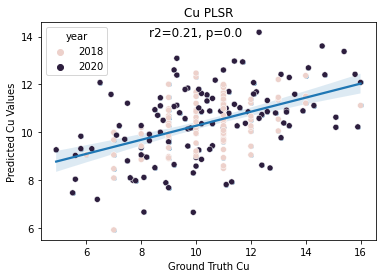

In [43]:
#plot the results
text1 = 'r2=%s, p=%s' % (text[0], text[1])
#sns.lmplot(x=trait, y='predicted',data=data_plot)
sns.regplot(x=trait, y='predicted' , scatter_kws={'s' : 15},data=data_plot)
xmin , xmax , ymin, ymax = plt.axis()
sns.scatterplot(x=trait, y='predicted', hue= 'year', data=data_plot).text((xmax)/2, ymax*0.96, text1, fontsize=12)
plt.xlabel('Ground Truth' + ' ' + trait)
plt.ylabel('Predicted' + ' ' + trait + ' ' + 'Values')
plt.title(trait + ' ' + 'PLSR')



In [44]:
data_2022 = pd.read_csv('sorghum_2022_whole.csv')

In [45]:
data_2022 =data_2022.loc[data_2022['355'].notnull(), :]

In [46]:
data_2022['CHL'] = data_2022[['CHLp1', 'CHLp2', 'CHLp3']].mean(axis=1)

In [47]:
data_2022['LWC'] = data_2022['LWC']/100

In [48]:
data_2022 = data_2022.loc[data_2022['Leaf_num'] != 2 , :]

In [49]:
#data_2022 = data_2022.loc[data_2022['Leaf_pos'] == 3 , :]

In [50]:
#data_2022 = data_2022.loc[data_2022['CHL']< 700 , :]

In [51]:
sns.boxplot(y= trait, data=data_2022)

ValueError: Could not interpret input 'Cu'

In [ ]:
import copy
data_test = copy.deepcopy(data_2022)


my_group = data_test.groupby(['Genotype', 'Rep']).mean()

my_group.head()

In [ ]:
my_group = my_group.reset_index(level=['Genotype', 'Rep'])

In [ ]:
outlier_treatment(my_group[trait])

In [ ]:
lowerbound,upperbound = outlier_treatment(my_group[trait])

In [ ]:
rm_index =my_group[(my_group[trait] < lowerbound) | (my_group[trait] > upperbound)].index
rm_index

In [ ]:
my_group.drop(rm_index, axis=0 ,inplace=True)

In [ ]:
y_test = my_group.loc[:, trait]

In [ ]:
y_test.shape

In [ ]:
X_total = my_group.iloc[:, 13:2164]

In [ ]:
X_total.drop(columns = X_total.columns[0:100], inplace = True) 

In [ ]:
X_total

In [ ]:
#select the columns of HR data
spec_columns2 = X_total.columns

In [ ]:
# Apply Savitzky Golay Filter
X_total = savgol_filter(X_total, window_length=5 , polyorder = 2)
X_total = pd.DataFrame(X_total, columns= spec_columns2)

In [ ]:
X_total.head()

In [ ]:
column_filter = np.arange(0,2050,5)  ## creating an index for column filtering
X_test= X_total.iloc[:, column_filter] # selecting the filtered columns 

In [ ]:
X_test.head()

In [ ]:
#define the cv
cv = RepeatedKFold(n_splits=10)
mse = []

In [ ]:
#Calculate MSE using cross-validation, adding one component at a time
#for i in np.arange(1, 40):
 #   pls = PLSRegression(n_components=i)
  #  score = -1*model_selection.cross_val_score(pls, X, y, cv=cv,
   #            scoring='neg_mean_squared_error').mean()
    #mse.append(np.sqrt(score))

In [ ]:
#n_comp = mse.index(min(mse)) +1 

In [ ]:
rsqu = [] 
for i in np.arange(1, 50):
    pls = PLSRegression(n_components= i)
    pls.fit(X, y)
    y_pred = pls.predict(X_test)
    r , p = spearmanr(y_test , y_pred)
    rsqu.append(r**2)
    n_comb = rsqu.index(max(rsqu)) +1

In [ ]:
# Train the model
pls = PLSRegression(n_components=n_comb)
pls.fit(X, y)

In [ ]:
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

In [ ]:
y_pred = pls.predict(X_test)

In [ ]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted' + ' ' + trait +  ' ' 'values')
plt.xlabel('Ground truth LWC measurements')
sns.regplot(x = y_test , y = y_pred)


In [ ]:
from scipy.stats import pearsonr, spearmanr
y_pred2 = [x[0] for x in y_pred]

r, p = spearmanr(y_test, y_pred2)
r2 = r**2
print(r2, p)

In [ ]:
rsqu